# HackOn(Data)
## Competition Challenge

Welcome to our project. We have decided to do a simple Forecasting on the salesRank, more precesilly, 

** The problem:** Knowing the first set of reviews of a product forecast the salesRank of it. 

** Hypothesis:** The reviews are an indicative of how well a product is selling and contain enough information for a forecast.

** Assumptions:** 

- We ommit that the data is seasonal.
- By product we mean the combination of product and vendors, that is represented by the asin.
- What else?

** NOTE: ** This notebook is intended to show the overall ideas and, in order to make it easier to read, we have sacrificed speed. In the last section when talking about scalability we dwell into these details.

# Part 0 - Loading the tools

We load the tools we will be using during this project.

In [1]:
import pandas as pd
import numpy as np
import fasttext
import gzip
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb

from collections import Counter

from sklearn.preprocessing import MultiLabelBinarizer #To be used with the categories feature
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error

%matplotlib inline  

/home/felipe/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Part 1- Cleaning and preparing The Data

In this section we load the data, clean it, and prepare it for feature building. The data consists on

### **Review Data**

This dataset contains product reviews and metadata from Amazon, including 142.8 million reviews spanning May 1996 - July 2014.

This dataset includes reviews (ratings, text, helpfulness votes), product metadata (descriptions, category information, price, brand, and image features), and links (also viewed/also bought graphs).

### **Q&A Data**

This dataset contains Questions and Answers data from Amazon, totaling around 1.4 million answered questions.

This dataset can be combined with Amazon product review data, by matching ASINs in the Q/A dataset with ASINs in the review data. The review data also includes product metadata (product titles etc.).

### **Credits:**

-  **R. He, J. McAuley**. Modeling the visual evolution of fashion trends with one-class collaborative filtering. WWW, 2016 J. 
- ** McAuley, C. Targett, J. Shi, A. van den Hengel **. A Image-based recommendations on styles and substitutes. SIGIR, 2015


We start with the scripts provided at [Julian McAuley's website](http://jmcauley.ucsd.edu/data/amazon/).

In [2]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

and use these methods to load the data

In [3]:
df_reviews = getDF('./data/reviews_Video_Games_5.json.gz')
df_meta=getDF('./data/meta_Video_Games.json.gz')
df_qa=getDF('./data/qa_Video_Games.json.gz')

We now study the different features.


## Features from the meta file

### SalesRank

Note that the dataframe that contains the salesRank is df_meta. In this data there are two possible cases where the values described are not helpful. The first one is a NaN value, and we can use is null method to deal with this, the second one is the case of a dictionary no containing the relevant key. We use a helper function to help us with this.

In [4]:
RELEVANT_KEY='Video Games'
def helper(dictionary):
    try:
        return dictionary[RELEVANT_KEY]
    except:
        return float('NaN')

In [5]:
df_meta['salesRank']=df_meta.salesRank.map(lambda x: helper(x))

We can now count how many entries don't have the desired rank 
data.

In [6]:
df_meta.salesRank[(df_meta.salesRank.isnull())].shape[0]

5675

and proceed to remove these rows 

In [7]:
df_meta=df_meta[ df_meta.salesRank.notnull()]

We can do a sanity check 

In [8]:
df_meta.salesRank[(df_meta.salesRank.isnull())].shape[0]

0

### imUrl

This features contains the web address to an image. As ee won't be using the images, so we drop this column.

In [9]:
df_meta=df_meta.drop('imUrl',axis=1)

### Title and brand

From the fact that the percentage of articles with title or brands are

In [10]:
print("Only %.2f%% of the products have title."%(df_meta.title.count()/df_meta.asin.count()*100))
print("Only %.2f%% of the products have brand."%(df_meta.brand.count()/df_meta.asin.count()*100))

Only 0.22% of the products have title.
Only 0.11% of the products have brand.


We can deduce that this features are not relevant, and so we drop them as well.

In [11]:
df_meta=df_meta.drop(['title','brand'],axis=1)

### Price

The feature price is definitely relevant for the  forecasting, now note that 

In [12]:
print("%.2f%% of the products have a price."%(df_meta.price.count()*100/df_meta.asin.count()))

88.25% of the products have a price.


as this is a relevant feature we remove the rows with missing data.

In [13]:
df_meta=df_meta[df_meta.price.notnull()]

Another sanity check.

In [14]:
print("%.2f%% of the products have a price."%(df_meta.price.count()*100/df_meta.asin.count()))

100.00% of the products have a price.


After this cleaning 

In [15]:
print("There are %d products left"%df_meta.asin.count())

There are 39959 products left


### Categories

The categories feature comes as a list of lists, let's first find out how many different categories are there.

In [16]:
categories=set()
for list_cats in df_meta.categories:
    for list_cat in list_cats:
        categories=categories.union(set(list_cat))
categories=list(categories)
print("There are %d categories"%len(categories))

There are 334 categories


we use these as a categorial variable, first we create a unique list of categories for each product

In [17]:
def helper2(list_cats):
    cats=set()
    for list_cat in list_cats:
        cats=cats.union(set(list_cat))
    return list(cats)

In [18]:
df_meta['categories']=df_meta.categories.apply(helper2)

and then we use the [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) from sklearn to do the encodding. 

In [19]:
mlb=MultiLabelBinarizer()
mlb.fit(df_meta.categories)
categories_df=pd.DataFrame(mlb.transform(df_meta.categories),columns=list(mlb.classes_))
df_meta.reset_index(drop=True,inplace=True)
df_meta=df_meta.merge(categories_df,left_index =True,right_index =True)

and finally we drop the categories column.

In [20]:
df_meta=df_meta.drop('categories',axis=1)

### related and decription

(ARE WE USING THIS?, RELATED MAY GIVE NICE INFO, BUT DESCRIPTION SEEMS USELESS)

We won't be using this either, so we remove them.

In [21]:
df_meta=df_meta.drop(['related','description'],axis=1)

## Features from the reviews file

### reviewText

This feature containing the review will be used for sentiment analysis. We come back to this when building features. For now, we just get rid of the data with empty reviews.

In [22]:
print("There are %d empty reviews."%df_reviews[df_reviews.reviewText==""].shape[0])
df_reviews=df_reviews[df_reviews.reviewText!=""]

There are 44 empty reviews.


### summary

We won't be using this feature, so we drop it

In [23]:
df_reviews=df_reviews.drop('summary',axis=1)

### reviewTime

This feature is redundant since we have unixReviewTime, so we also get rid of this

In [24]:
df_reviews=df_reviews.drop('reviewTime',axis=1)

### ReviewerName
This is also redundant, since we have the reviewerID, we drop it

In [25]:
df_reviews=df_reviews.drop('reviewerName',axis=1)

# Part 2 - Feature engineering

In this part we build our features, this will be done in the following order.


- Use sentiment analysis to give a sentiment score to the reviews. (Reason: a score of 3 for two people may mean different things the sentiment wil help correct this)

- ReviewerID features: will help us gain confidence in the review.

- helpful: Increases the confidence.

- ReviewTime: To create a time series for the (cummulative) number of reviews.

- Categories: Create category 'Other' and move everything that is not in the top 20 categories to the 'Other' category.


### Sentiment Analysis on reviews

We use fasttext from facebook [CITE] to create an score. For this we need to save the data we need to a text file, since that is the signature of the training method of fasttext.

In [26]:
df_sentiment=df_reviews.loc[:,('reviewText','overall')]
df_sentiment['overall']=df_sentiment.overall.apply(lambda x: '__label__'+str(int(x)))
df_sentiment.to_csv(r'./data_/data_for_sentiment.txt', header=None, index=None, sep=' ', mode='a')

Now, that the data is prepared for procesing, we can use the classifier.

In [27]:
classifier = fasttext.supervised('./data_/data_for_sentiment.txt', 'model', label_prefix='__label__')

and do a simple, sanity check

In [28]:
texts=["this is an awesome","this sucks"]
labels = classifier.predict(texts)
print(labels)

[['5'], ['1']]


and we can add this feature to the reviews dataframe

In [29]:
df_reviews['sentimentScore']=df_reviews.reviewText.apply(
    lambda x:int(classifier.predict([x])[0][0]))

as that was our use of the textReview feature we can get rid of it.

In [30]:
df_reviews=df_reviews.drop('reviewText',axis=1)

In [31]:
df_reviews.head()

,unixReviewTime,overall,helpful,reviewerID,asin,sentimentScore
0,1341792000,1.0,"[8, 12]",A2HD75EMZR8QLN,0700099867,1
1,1372550400,4.0,"[0, 0]",A3UR8NLLY1ZHCX,0700099867,4
2,1403913600,1.0,"[0, 0]",A1INA0F5CWW3J4,0700099867,1
3,1315958400,3.0,"[7, 10]",A1DLMTOTHQ4AST,0700099867,1
4,1308009600,4.0,"[2, 2]",A361M14PU2GUEG,0700099867,5


### ReviewerID

We want to measure the quality of a review, so far we only have a values for this, the helpful feature. We add a new feature that comes from the reviewerID where we say that a review has better quality the larger the number of reviews the corresponding revierID has. We start by counting frequencies of the reviewerID. 

In [32]:
value_counts_reviewerID=df_reviews.reviewerID.value_counts().to_dict()

and add the feature reviewerQuality

In [33]:
df_reviews['reviewerQuality']=df_reviews.reviewerID.apply(lambda x: value_counts_reviewerID[x])

as we won't be using the reviewerID anymore, we get rid of this feature.

In [34]:
df_reviews=df_reviews.drop('reviewerID',axis=1)

## Data aggregation

Before we continue with the feature generation, we need to agregate the data by product. This will make the features to be a time series, where the time is controled by the UnixReviewTime.


In [35]:
df_products = df_reviews.groupby('asin').agg(lambda x:(list(x)))

### helpful

In order to incorporate the helpful score into the product, we create two variables defined below:

$$ \text{helpfulOverall} = \sum \text{overall}_i \cdot \frac{\text{helpful}_i[0]}{\text{helpful}_i[1]} $$ 

and 

$$ \text{helpfulSentiment} = \sum \text{sentiment_score}_i \cdot \frac{\text{helpful}_i[0]}{\text{helpful}_i[1]} $$ 
where the sums run over the $i$ such that helpful$_i$[1]$\neq 0$.

We need a helper function to incorporate these new features.

In [36]:
def helper_helpful(A,B):
    total=0
    for a,b in zip(A,B):
        b1,b2=b
        if b2!=0:
            total+=a*b1/b2
    return total

In [37]:
df_products['helpfulOverall']=df_products.apply(lambda row: helper_helpful(row['overall'],row['helpful']),axis=1)
df_products['helpfulSentiment']=df_products.apply(lambda row: helper_helpful(row['sentimentScore'],row['helpful']),axis=1)

and we can drop the helpful feature now.

In [38]:
df_products=df_products.drop(['helpful'],axis=1)

### reviewerQuality

As we want to introduced an invariant that captures the quality of the review, we can use this in the same way as with helpful to produce two more features.

$$ \text{qualityOverall} = \sum \text{overall}_i \cdot \text{reviewerQuality}_i $$ 

and 

$$ \text{qualitySentiment} = \sum \text{sentiment}_i \cdot \text{reviewerQuality}_i $$ 

as before, we need a helper function

In [39]:
def helper_quality(A,B):
    total=0
    for a,b in zip(A,B):
        total+=a*b
    return total

In [40]:
df_products['qualityOverall']=df_products.apply(lambda row: helper_quality(row['overall'],row['reviewerQuality']),axis=1)
df_products['qualitySentiment']=df_products.apply(lambda row: helper_quality(row['sentimentScore'],row['reviewerQuality']),axis=1)

and we are ready to drop more features. 

In [41]:
df_products=df_products.drop(['overall','sentimentScore','reviewerQuality'],axis=1)

**REMARK:** The reader should note that there is a faster way to compute the last two features, readly starting from the df_reviews dataframe building the individual multiplications and then aggregating. We opted for the (significantly) slower way to make the notebook easier to read.

### The hotness feature

As the unixReviewTime is the number of seconds since 1970, we simplify this so it keeps track of the number of days instead, we create a feature to keep track of the first day and modify the feature to keep track of the days after the first day that the review was created.

In [42]:
df_products['unixReviewTime']=df_products.unixReviewTime.apply(lambda x: np.sort(np.array(x)//3600//24))
df_products['firstReviewDay']=df_products.unixReviewTime.apply(lambda x:x[0])
df_products['daysSinceFirstReview']=df_products.unixReviewTime.apply(lambda x: x- x[0])

The feature unixReviewTime is now irrelevant

In [43]:
df_products=df_products.drop('unixReviewTime',axis=1)

we add a feature called productLife, keeping track of when the last review took place, and another feature for the number of reviews, nunmberReviews.

In [44]:
df_products['productLife']=df_products.daysSinceFirstReview.apply(lambda x:x[-1])
df_products['numberReviews']=df_products.daysSinceFirstReview.apply(lambda x: len(x))

To illustrate the next feature we are going to create, we graph the number of reviews against the days after the first review, for a sample set of reviews

In [45]:
def create(days):
    X=[days[0]]
    Y=[0]
    current=0
    for day in days:
        if day==X[-1]:
            Y[current]+=1
        else:
            X.append(day)
            Y.append(Y[-1]+1)
            current+=1
    return X,Y

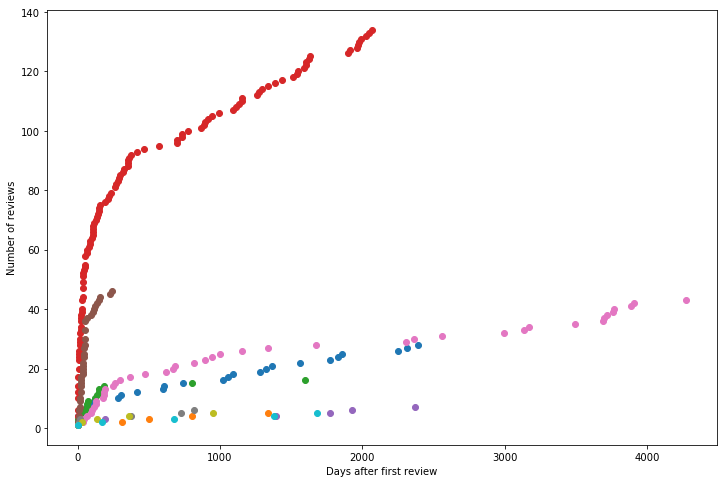

In [46]:
sample=df_products.sample(10)
fig=plt.figure(figsize=(12,8))
for days in sample.daysSinceFirstReview:
    
    X,Y=create(days)
    #print(X,Y)
    plt.plot(X, Y,'o')

plt.xlabel("Days after first review")
plt.ylabel("Number of reviews")
plt.show()

Let's make the following assumption:

**Assumption: The "better" a product is, the more reviews it would have when measure over periods of time**

In order to make this concrete, we can create a new invariant, we define 

**hotness** = area under the staircase formed by the curve in the interval where it is defined.

In [47]:
def compute_hotness(days):
    X,Y=create(days)
    #X=[0,20,30]
    #Y=[1,2,3]
    area=0
    for i in range(1,len(X)):
        area+=(X[i]-X[i-1])*Y[i-1]
    area+=Y[-1]

    return area

Let's add this feature

In [48]:
df_products['hotness']=df_products.daysSinceFirstReview.apply(lambda x:compute_hotness(x))

This concludes our feature creation, our next step is to set up the data for training.

# Creating the X and y's

We want to create a dataset containing the features our models will use. 

In [49]:
Xy_df= df_products.drop(['firstReviewDay','daysSinceFirstReview'],axis=1)
Xy_df=Xy_df.merge(df_meta, left_index=True,right_on='asin')

We select the columns of features and the column of predictions

In [50]:
#Xy_df['extra']=Xy_df.hotness.apply(np.log) (improves score by 0.001)
y=Xy_df.salesRank.as_matrix()
X=Xy_df.drop(['salesRank','asin'],axis=1).as_matrix()

now that we have the data we first separate it into train, validation, and test sets.

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2/0.9, random_state=13)

# some models (draft)

We create the models now

### Random Forest

In [52]:
RandomForestModel = RandomForestRegressor()

In [53]:
RandomForestModel.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [54]:
RandomForestModel.feature_importances_.argsort()[-20:][::-1]

array([  5,   4,   6,   7, 226,   1,   3,   0,   2, 208, 180, 143, 147,
       218,  63,  11, 335, 236, 195, 138])

In [55]:
RandomForestModel.score(X_val,y_val)

0.29634694596319489

In [56]:
np.sqrt(mean_squared_error(y_val,RandomForestModel.predict(X_val)))

9488.2920116962523

### Xgboost

In [57]:
xgb_model = xgb.XGBRegressor()

In [58]:
XGBModel = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6],
                    'n_estimators': [50,100,200],
                   }, verbose=1)

In [59]:
XGBModel.fit(X,y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  3.3min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 4, 6], 'n_estimators': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [60]:
r2_score(y_val,XGBModel.predict(X_val))

0.61375742611571416

In [61]:
np.sqrt(mean_squared_error(y_val,XGBModel.predict(X_val)))

7029.7329140848333

### LGB

In [62]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [63]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Start training...')
# train
GBMModel = lgb.train(params,
                lgb_train,
                num_boost_round=20, valid_sets=lgb_eval)

Start training...
[1]	valid_0's auc: 1	valid_0's l2: 1.26914e+08
[2]	valid_0's auc: 1	valid_0's l2: 1.25897e+08
[3]	valid_0's auc: 1	valid_0's l2: 1.24949e+08
[4]	valid_0's auc: 1	valid_0's l2: 1.24121e+08
[5]	valid_0's auc: 1	valid_0's l2: 1.23137e+08
[6]	valid_0's auc: 1	valid_0's l2: 1.22245e+08
[7]	valid_0's auc: 1	valid_0's l2: 1.21293e+08
[8]	valid_0's auc: 1	valid_0's l2: 1.20351e+08
[9]	valid_0's auc: 1	valid_0's l2: 1.19429e+08
[10]	valid_0's auc: 1	valid_0's l2: 1.18551e+08
[11]	valid_0's auc: 1	valid_0's l2: 1.17771e+08
[12]	valid_0's auc: 1	valid_0's l2: 1.16988e+08
[13]	valid_0's auc: 1	valid_0's l2: 1.16199e+08
[14]	valid_0's auc: 1	valid_0's l2: 1.1538e+08
[15]	valid_0's auc: 1	valid_0's l2: 1.14608e+08
[16]	valid_0's auc: 1	valid_0's l2: 1.13837e+08
[17]	valid_0's auc: 1	valid_0's l2: 1.13048e+08
[18]	valid_0's auc: 1	valid_0's l2: 1.1241e+08
[19]	valid_0's auc: 1	valid_0's l2: 1.11672e+08
[20]	valid_0's auc: 1	valid_0's l2: 1.10962e+08


In [64]:
r2_score(y_val, GBMModel.predict(X_val))

0.13272323251822371

In [65]:
np.sqrt(mean_squared_error(y_val,GBMModel.predict(X_val)))

10533.861646213129